In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install scikit-learn catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00


In [ ]:
import kagglehub

path = kagglehub.dataset_download("osmi/mental-health-in-tech-survey")

print("Path to dataset files:", path)

100%|██████████| 48.8k/48.8k [00:00<00:00, 1.90MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/osmi/mental-health-in-tech-survey/versions/3


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Altere para a pasta que você salvou (drive)
survey_path = "/content/drive/{MyDrive/Colab Notebooks}/archive/survey.csv"

df = pd.read_csv(survey_path)

df = df[["Age","Gender","self_employed","family_history",
         "treatment","work_interfere","no_employees","remote_work","tech_company","benefits",
         "care_options","wellness_program","seek_help","anonymity",
         "mental_health_consequence",
         "coworkers","supervisor",
         "mental_vs_physical","obs_consequence"]]

df = df[(df["Age"] >= 18) & (df["Age"] <= 72)]

df["Gender"] = df["Gender"].str.strip().str.lower()
male_terms = ["male", "m", "man", "cis male", "cis man", "male (cis)",
        "msle", "maile", "mal", "malr", "make", "mail", "guy", "man"]
female_terms = ["female", "f", "woman", "cis female", "cis-female/femme",
        "femake", "femail", "female (cis)", "femake", "femake",
        "trans woman", "trans-female", "female (trans)"]
df["Gender"] = df["Gender"].apply(lambda x: "Male" if x in male_terms else ("Female" if x in female_terms else "Other"))

for col in ["benefits", "anonymity", "supervisor", "care_options", "remote_work"]:
    df[col].fillna(df["benefits"].mode()[0], inplace=True)

# NOVAS FEATURES
df["high_risk_support"] = ((df["family_history"] == "Yes") & (df["benefits"] == "No")).astype(int)
df["support_gap"] = ((df["benefits"] == "Yes") & (df["care_options"] != "Yes")).astype(int)
df["mental_and_anonymity"] = ((df["mental_health_consequence"] == "Yes") & (df["anonymity"] == "Yes")).astype(int)
df["remote_benefits"] = ((df["remote_work"] == "Yes") & (df["benefits"] == "No")).astype(int)
df["remote_care"] = ((df["remote_work"] == "Yes") & (df["care_options"] == "Yes")).astype(int)

cols_to_fill = ['benefits', 'anonymity', 'care_options', 'remote_work',
                  'mental_health_consequence', 'family_history']
for col in cols_to_fill:
    df[col].fillna(df[col].mode()[0], inplace=True)

binary_map = {"Yes": 1, "No": 0}
for col in ["tech_company", "family_history", "remote_work"]:
    df[col] = df[col].map(binary_map)

# SEPARAÇÃO PARA TREINO 80/20
X = df.drop("treatment", axis=1)
y = df["treatment"].map(binary_map)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

for col in ['self_employed', 'work_interfere']:
    mode = X_train[col].mode()[0]
    X_train[col].fillna(mode, inplace=True)
    X_test[col].fillna(mode, inplace=True)

interfere_map = {"Never": 0, "Rarely": 1, "Sometimes": 2, "Often": 3}
X_train["work_interfere"] = X_train["work_interfere"].map(interfere_map)
X_test["work_interfere"] = X_test["work_interfere"].map(interfere_map)

employee_map = {
    "1-5": 0, "6-25": 1, "26-100": 2, "100-500": 3, "500-1000": 4, "More than 1000": 5
}
X_train["no_employees"] = X_train["no_employees"].map(employee_map)
X_test["no_employees"] = X_test["no_employees"].map(employee_map)


/tmp/ipython-input-1406125437.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df["benefits"].mode()[0], inplace=True)
/tmp/ipython-input-1406125437.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [ ]:
# ONE-HOT ENCODING
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

X_train_encoded = X_train_encoded.astype(int)
X_test_encoded = X_test_encoded.astype(int)

# GARANTIR MESMA ORDEM
X_train_final, X_test_final = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_model.fit(X_train_final, y_train)
y_pred_dummy = dummy_model.predict(X_test_final)

accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
f1_dummy = f1_score(y_test, y_pred_dummy)

y_prob_dummy = dummy_model.predict_proba(X_test_final)[:, 1]
roc_auc_dummy = roc_auc_score(y_test, y_prob_dummy)

print(f"Acurácia do Baseline: {accuracy_dummy:.4f}")
print(f"F1-Score do Baseline: {f1_dummy:.4f}")
print(f"ROC-AUC do Baseline: {roc_auc_dummy:.4f}")

Acurácia do Baseline: 0.5060
F1-Score do Baseline: 0.6720
ROC-AUC do Baseline: 0.5000


In [ ]:
# RANDOM FOREST

print("\n" + "="*50)
print("TREINANDO O MODELO RANDOMFOREST")
model =  RandomForestClassifier(n_estimators=300,
                                n_jobs=-1,
                                max_depth=10,
                                max_features='sqrt',
                                random_state=42,
                                min_samples_leaf=10,
                                min_samples_split=20
                                )
model.fit(X_train_final, y_train)

y_pred = model.predict(X_test_final)
print("Acurácia:", accuracy_score(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
print(f"\nF1-Score (para a classe 'Buscou tratamento'): {f1:.4f}")


TREINANDO O MODELO RANDOMFOREST
Acurácia: 0.7649402390438247

F1-Score (para a classe 'Buscou tratamento'): 0.7631



ANÁLISE MODELO BASE (SEM FEATURES)


Relatório de classificação
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       124
           1       0.78      0.75      0.76       127

    accuracy                           0.76       251
   macro avg       0.77      0.77      0.76       251
weighted avg       0.77      0.76      0.76       251

ROC-AUC Score: 0.8526


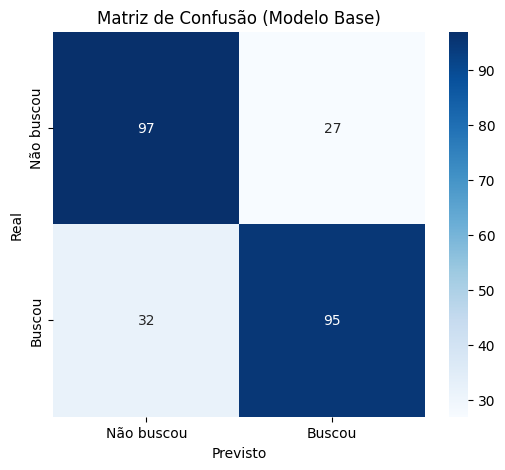

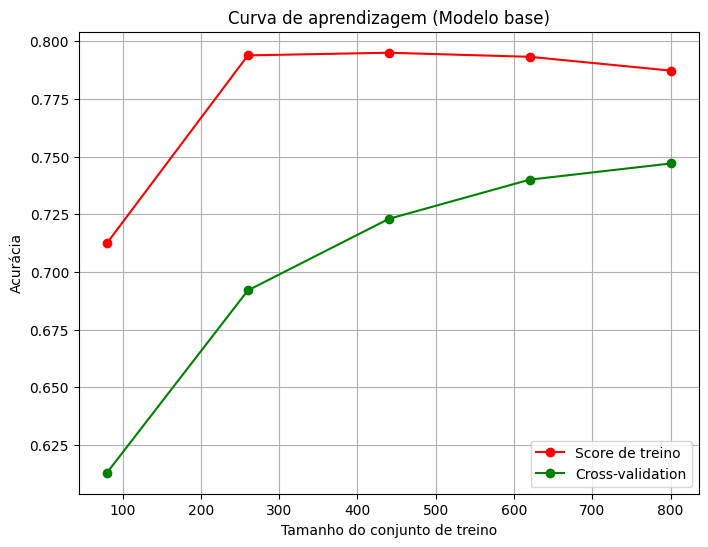

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import learning_curve
import shap

print("\nANÁLISE MODELO BASE (SEM FEATURES)\n")

print("\nRelatório de classificação")
print(classification_report(y_test, y_pred))

y_prob = model.predict_proba(X_test_final)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não buscou", "Buscou"],
            yticklabels=["Não buscou", "Buscou"])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão (Modelo Base)")
plt.show()

print("\n\n")

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_final, y_train, cv=5, n_jobs=-1,
    scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5)
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.title("Curva de aprendizagem (Modelo base)")
plt.xlabel("Tamanho do conjunto de treino")
plt.ylabel("Acurácia")
plt.grid()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de treino")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation")
plt.legend(loc="best")
plt.show()


Importância das features


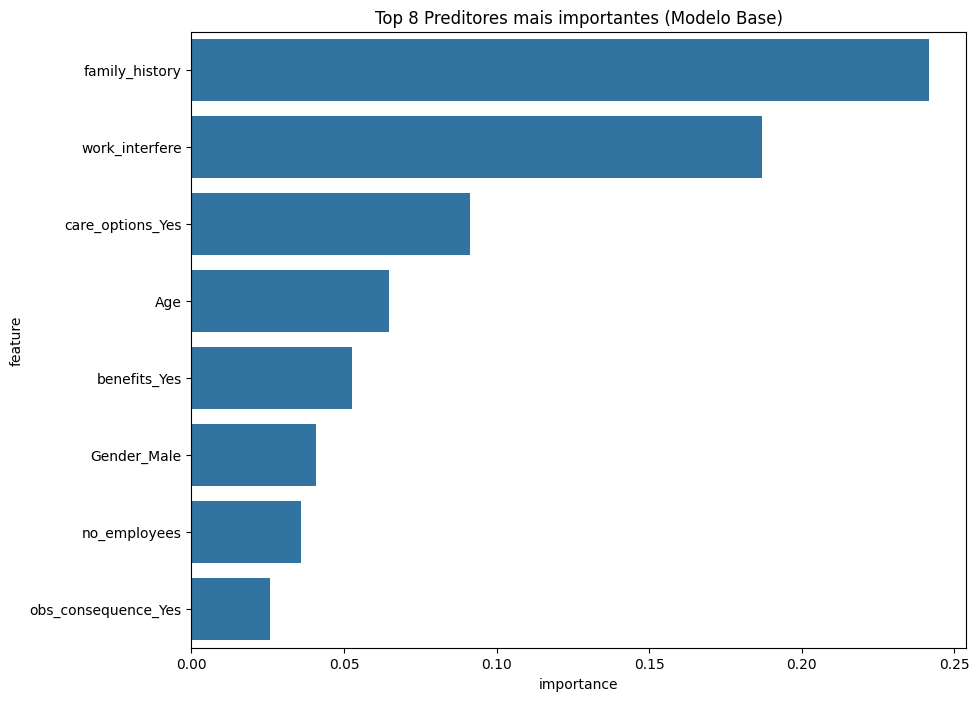

In [ ]:
print("\nImportância das features")
importances = model.feature_importances_
feature_names = X_train_final.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(8))
plt.title('Top 8 Preditores mais importantes (Modelo Base)')
plt.show()